Here we want to code data into a sequence of characters, where each character refers to one or multidimentional data parameter (factor). Factors should be represented as categorical data, with limited amount of levels. Then we look for a repetitive patterns in the sequence.

The pipeline:

0. Clean the data
1. Compute metrics. Clean the data based on metrics
2. Create factors from metrics
3. Convert factors to sequences
4. Find patterns in sequences
5. Visualize
6. Compute features on data and clusterize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Append utils as a module
module_path = os.path.abspath(os.path.join('utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Reload modules after they were changed 
%load_ext autoreload
%autoreload 2

# Load functions for feature extraction and processing
from move_direction import move_abs_direction
from move_length import move_length
from data_preprocessing import *
from data_to_segments import *
from plot_helpers import *
from data_to_char import code_factors_in_chars
from patterns import find_patterns, patterns_coverage, pattern_mask

In [2]:
# Load the data set from eye-tracker
raw_df = pd.read_csv('data/et_raw_data.csv')
print(raw_df.shape)
raw_df.head()

(1999941, 9)


,fix,x,y,blink,time,frame,user,task,frame_num
0,1,0.37455,0.09229,0,0.00000,2_news_0,2,news,0
1,1,0.37268,0.09873,0,0.03284,2_news_1,2,news,1
2,1,0.36792,0.09157,0,0.06604,2_news_2,2,news,2
3,1,0.36680,0.08825,0,0.09863,2_news_3,2,news,3
4,1,0.36246,0.07916,0,0.13147,2_news_4,2,news,4


We will compute <b>*gaze movement direction*</b> and <b>*movement length*</b> and use them as factors. Thus, patterns will be two-dimensional. 

In [3]:
# Set up parameters for patterns

PATTERN_LEN = 4 # The length of pattern

N_DIRECTIONS = 8 # number of segments in movement directions data
N_LENGTH = 5 # number of segments in movement lenght data (choose from odd number)

Initial shape (1999941, 9)


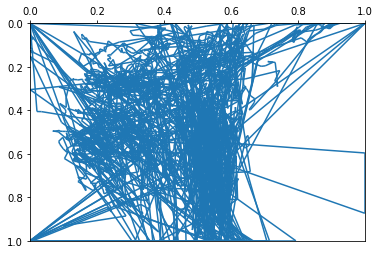

removed blinks and non-fixations (1419401, 9)


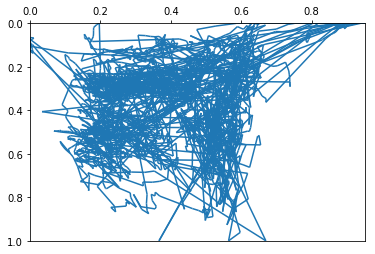

removed jittering (1281403, 9)
merged same direction (804827, 9)


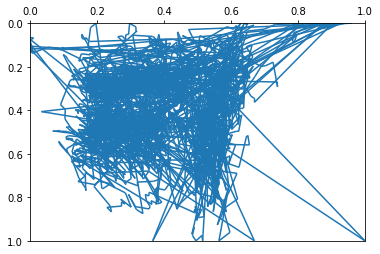

In [4]:
## 1. Clean the data
## 2. Compute the metrics and filter the data based on computed metrics
## (if we want to smooth or simplify trajectories)

df = raw_df.copy()
print("Initial shape", df.shape)
p = plot_path(df[['x', 'y']].values[:5000])
plt.show()

df = df[df['fix'] == 1] # leave only fixations
df = df[df['blink'] != 1] # filter rows with blinks
df.x = df.x.clip(0, 1) # limit x and y values
df.y = df.y.clip(0, 1) # limit x and y values

print("removed blinks and non-fixations", df.shape)
p = plot_path(df[['x', 'y']].values[:5000])
plt.show()

# Filter movements less than delta
df = remove_tiny_moves(df, delta=0.001)
print("removed jittering", df.shape)

# Merge movements to the same direction
df = merge_same_direction(df, n_directions=N_DIRECTIONS)
print("merged same direction", df.shape)

p = plot_path(df[['x', 'y']].values[:5000])
plt.show()

In [5]:
# 3. Create factors from metrics

# - Movement direction
move_dir = move_abs_direction(df.x, df.y, invert_y=True)
factor_dir = angle_to_segments(move_dir, n_segments=N_DIRECTIONS, segment_ranges=True)

# - Length of movement
move_len = move_length(df.x, df.y)
move_len_log = np.log(move_len)

factor_len_log = data_to_segments_quantile(move_len_log, n_segments=N_LENGTH, segment_ranges=True)

# - Move time

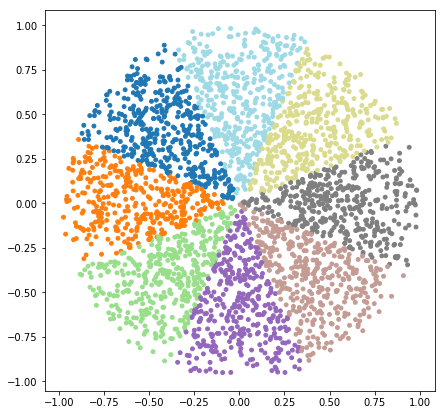

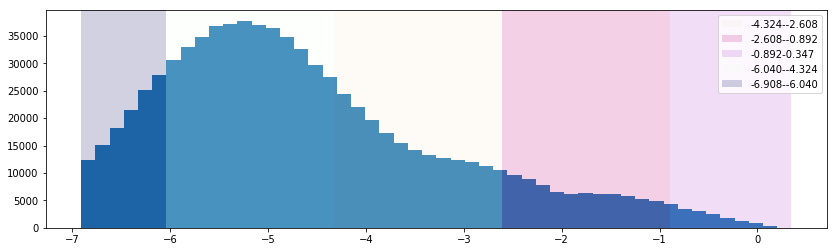

In [6]:
# Visualize segments (for directions)
p = plot_dir_segments(n_segments=N_DIRECTIONS, n=3000)
plt.show()

# Visualize segments (for log-length)
p = plot_len_segments(move_len_log, factor_len_log)
plt.show()

In [ ]:
# factor_len = data_to_segments_quantile(move_len, n_segments=N_LENGTH, segment_ranges=True)

# # Visualize segments (for length)
# p = plot_len_segments(move_len, factor_len)
# plt.show()

In [7]:
# 4. Convert factors to sequences
seq, codes = code_factors_in_chars([factor_dir, factor_len_log])
for k, v in codes.items():
    print("## {} ##:  dir {}-{}, len {:.3f} - {:.3f}".format(k, v[0], v[1], v[2], v[3]))

# 5. Find patterns in sequences
patterns = find_patterns(seq, n_chars=PATTERN_LEN)
patterns_counts = patterns_coverage(patterns, len(seq))

## m ##:  dir 315.0-359.99934113637397, len -2.608 - -0.892
## U ##:  dir 180.0-225.0, len -6.908 - -6.040
## K ##:  dir 90.0-135.0, len -6.908 - -6.040
## E ##:  dir 0.0-45.0, len -0.892 - 0.347
## V ##:  dir 180.0-225.0, len -6.040 - -4.324
## L ##:  dir 90.0-135.0, len -6.040 - -4.324
## M ##:  dir 90.0-135.0, len -4.324 - -2.608
## H ##:  dir 45.0-90.0, len -4.324 - -2.608
## f ##:  dir 270.0-315.0, len -6.040 - -4.324
## b ##:  dir 225.0-270.0, len -4.324 - -2.608
## a ##:  dir 225.0-270.0, len -6.040 - -4.324
## F ##:  dir 45.0-90.0, len -6.908 - -6.040
## j ##:  dir 315.0-359.99934113637397, len -6.908 - -6.040
## R ##:  dir 135.0-180.0, len -4.324 - -2.608
## X ##:  dir 180.0-225.0, len -2.608 - -0.892
## W ##:  dir 180.0-225.0, len -4.324 - -2.608
## n ##:  dir 315.0-359.99934113637397, len -0.892 - 0.347
## T ##:  dir 135.0-180.0, len -0.892 - 0.347
## Q ##:  dir 135.0-180.0, len -6.040 - -4.324
## d ##:  dir 225.0-270.0, len -0.892 - 0.347
## O ##:  dir 90.0-135.0, len -0.89

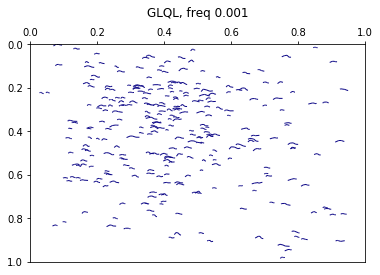

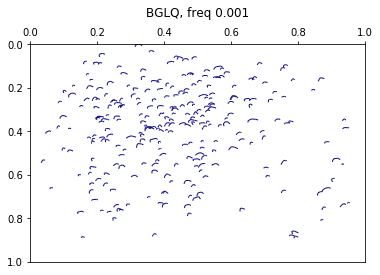

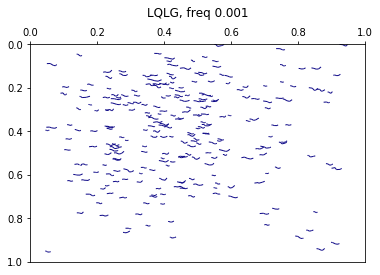

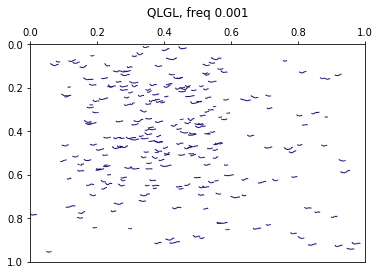

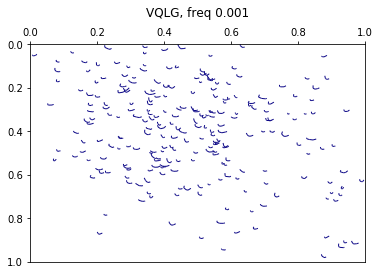

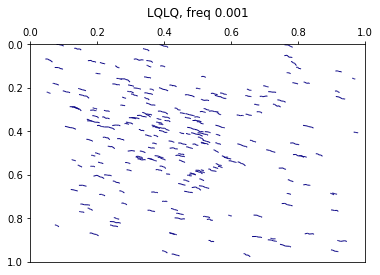

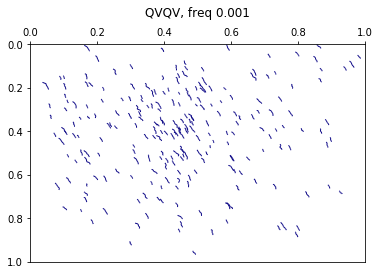

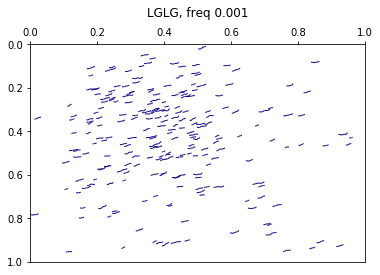

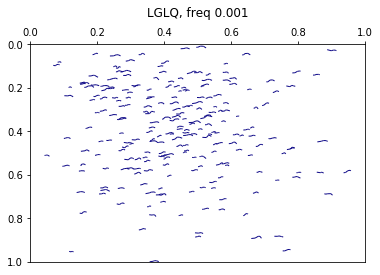

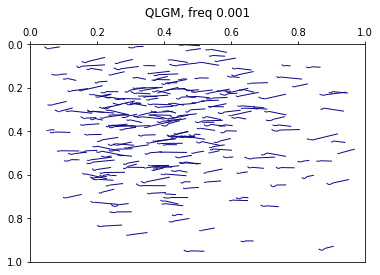

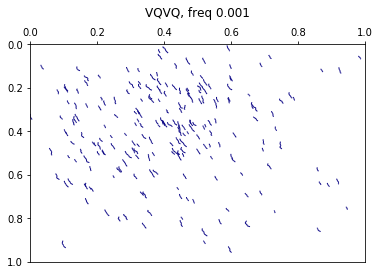

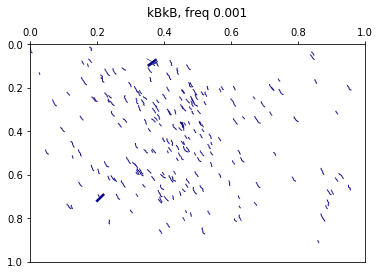

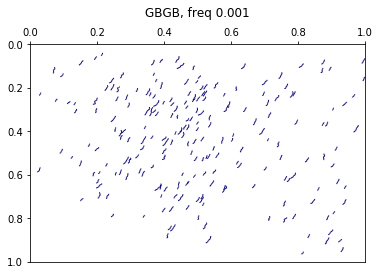

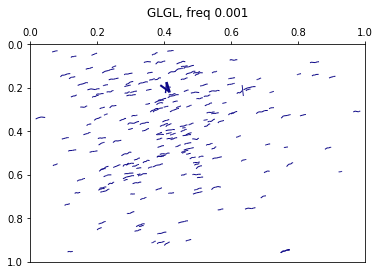

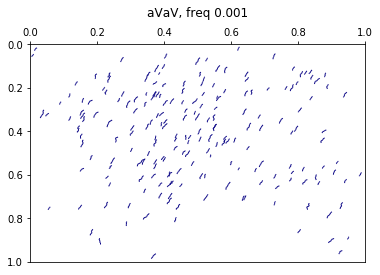

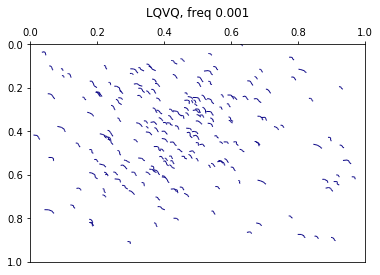

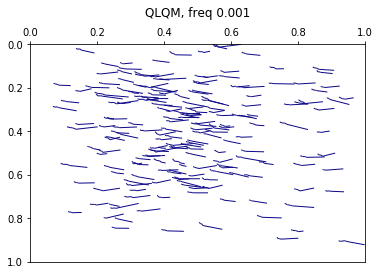

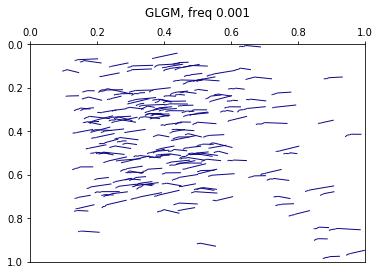

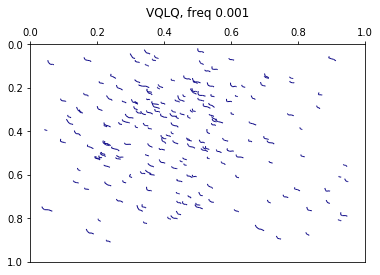

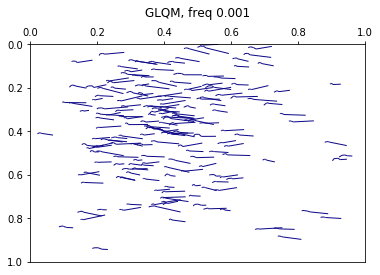

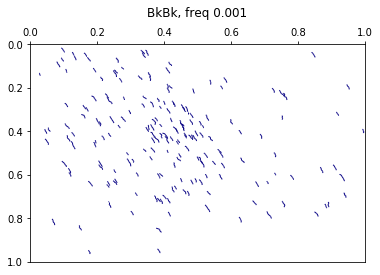

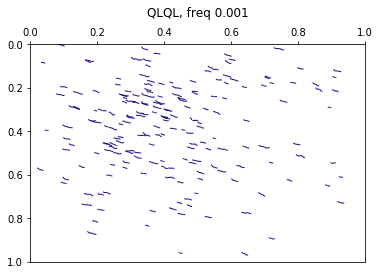

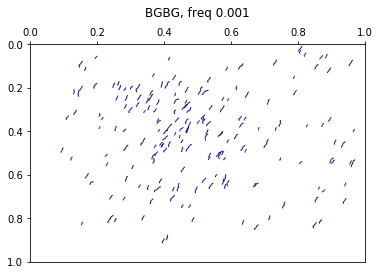

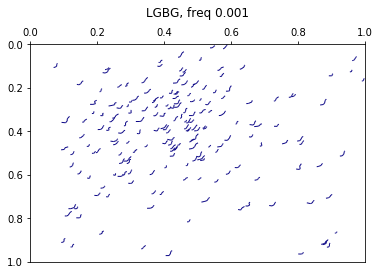

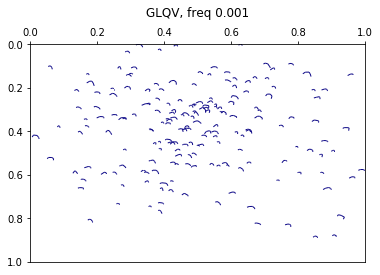

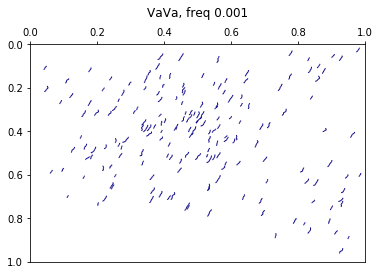

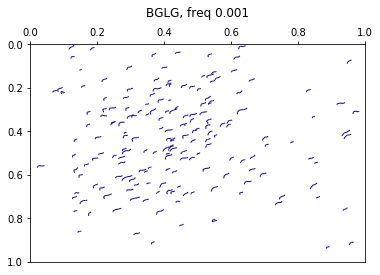

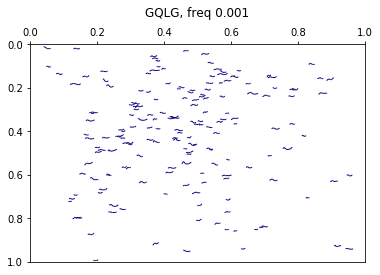

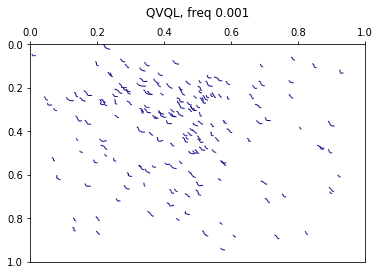

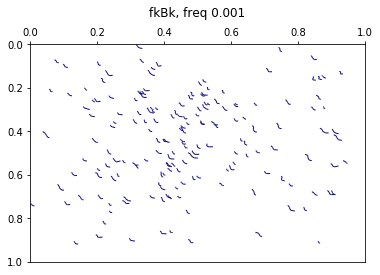

In [8]:
# 6. Visualize

for n, (pat, pat_count) in enumerate(patterns_counts[:30]):
    pat_mask = pattern_mask(seq, pat)
    pat_title = '{}, freq {:.3f}'.format(pat, pat_count)
    p = plot_path(df[['x', 'y']].values, segments_weights=pat_mask, only_weighted=True,
              colorbar=False, figsize=(6, 4), title=pat_title)
    plt.show()

patterns:  261446


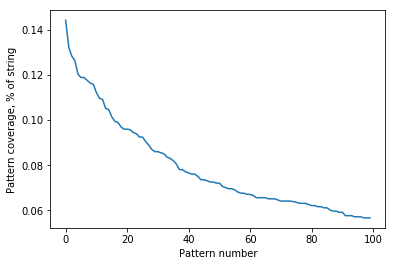

In [9]:
# Plot distribution of patterns by freq
print("patterns: ", len(patterns_counts))
plt.plot([x[1]*100 for x in patterns_counts[:100]])
plt.ylabel('Pattern coverage, % of string')
plt.xlabel('Pattern number')
plt.show()

patterns:  398852


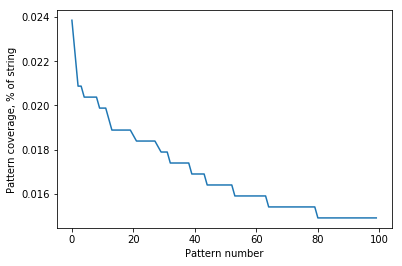

In [10]:
from random_string_test import random_seq, plot_coverage_comparison

# Random permutation test
random_s = random_seq(len(seq), from_seq=list(seq), merge_repetitions=True)
random_patterns = find_patterns(random_s, n_chars=PATTERN_LEN)
random_patterns_counts = patterns_coverage(random_patterns, len(seq))

# Plot distribution of patterns by freq
print("patterns: ", len(random_patterns_counts))
plt.plot([x[1]*100 for x in random_patterns_counts[:100]])
plt.ylabel('Pattern coverage, % of string')
plt.xlabel('Pattern number')
plt.show()

34.33% of the sequence covered by top 1000 patterns
11.79% of the random sequence covered by top 1000 patterns


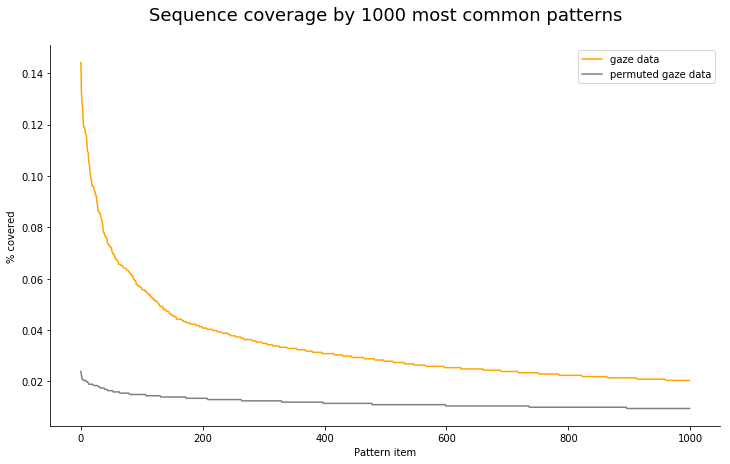

In [14]:
n = 1000
p_coverage = [x[1] for x in patterns_counts[:n]]
print("{:.2f}% of the sequence covered by top {} patterns".format(np.sum(p_coverage)*100, n))
rand_p_coverage = [x[1] for x in random_patterns_counts[:n]]
print("{:.2f}% of the random sequence covered by top {} patterns".format(np.sum(rand_p_coverage)*100, n))

p = plot_coverage_comparison(p_coverage, rand_p_coverage)
plt.show()

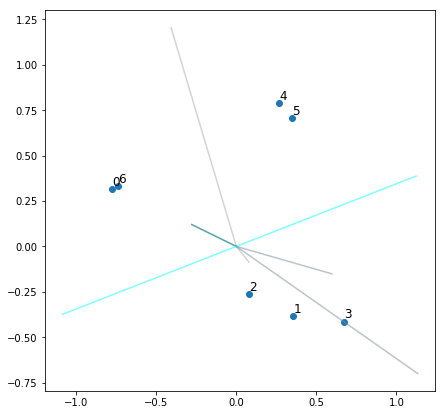

In [10]:
p = plot_chunks_example(n_segments=N_DIRECTIONS, n=12)
plt.show()

In [ ]:
# 7. TO DO: Compute features on data and clusterize